In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# from IPython.core.debugger import set_trace
# set_trace()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import time
from PIL import Image

In [ ]:
pathToZip = '/content/drive/MyDrive/DataSets/Cars/RefactoredCars.zip'

z = zipfile.ZipFile(pathToZip, 'r')
z.extractall('/content/sample_data/')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import os

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [ ]:
# Define transforms for dataset

trainTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.3)
])

validTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

testTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [ ]:
# Loading dataset
rootPath = '/content/sample_data/'#'/content/drive/MyDrive/DataSets/Birds'
trainPath = os.path.join(rootPath, 'TrainImages')
testPath = os.path.join(rootPath, 'TestImages')
validPath = os.path.join(rootPath, 'ValidImages')

if not (os.path.exists(trainPath) and os.path.exists(testPath) and os.path.exists(validPath)):
  print('Could not find dataset')

trainSet = dset.ImageFolder(trainPath)#, trainTransforms)
validSet = dset.ImageFolder(validPath, validTransforms)
testSet = dset.ImageFolder(testPath, testTransforms)

AttributeError: ignored

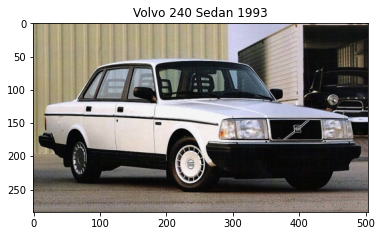

In [ ]:
x, y = trainSet[8000]
# print(len(trainSet))

className = list(trainSet.class_to_idx.keys())[list(trainSet.class_to_idx.values()).index(y)] # Get name of class
plt.title(className)
plt.imshow(x.permute(1, 2, 0))
print('image size - ', x.shape)
print('Num_classes - ', len(trainSet.class_to_idx))

In [ ]:
import cv2

In [ ]:
type(trainSet[0])

tuple

In [ ]:
src = cv2.imread('/content/sample_data/TrainImages/AM General Hummer SUV 2000/00163.jpg', cv2.IMREAD_UNCHANGED)


In [ ]:
newImg = cv2.resize(src, (224, 224))

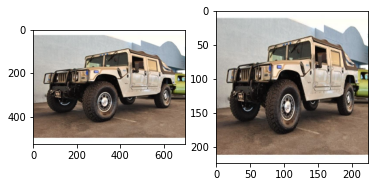

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(src)
plt.subplot(1, 2, 2)
plt.imshow(newImg)

In [ ]:
trainLoader = DataLoader(trainSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, trainSet.__len__())))
validLoader = DataLoader(validSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, validSet.__len__())))
testLoader = DataLoader(testSet, batch_size=64)

In [5]:
"""
ResNet from this paper Deep Residual Learning for Image Recognition https://arxiv.org/pdf/1512.03385.pdf
"""



class resNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()

        self.expansion = 4
        self.identity_downsample = identity_downsample

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.batchNorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels= self.expansion*out_channels, kernel_size=1, stride=1, padding=0)
        self.batchNorm3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()

    def forward(self, x):

        identity = x

        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.batchNorm3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):

    def __init__(self, block, layers, image_channels, num_classes):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layers(block, layers[0], out_channels=64, stride = 1)
        self.layer2 = self._make_layers(block, layers[1], out_channels=128, stride = 2)
        self.layer3 = self._make_layers(block, layers[2], out_channels=256, stride = 2)
        self.layer4 = self._make_layers(block, layers[3], out_channels=512, stride = 2)

        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.pool2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x



    def _make_layers(self, block, num_residual_blocks, out_channels, stride):

        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != 4 * out_channels: # Если шаг ведёт к понижению размерности или итоговые каналы не совпадают с изначальными
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride), # то нужен метод приведения к одной размерности
                                                nn.BatchNorm2d(out_channels * 4)
                                                )
            
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


def create_ResNet50(img_channels=3, num_classes=1000):
    return ResNet(resNetBlock, [3, 4, 6, 3], img_channels, num_classes)

def create_ResNet152(img_channels=3, num_classes=1000):
    return ResNet(resNetBlock, [3, 8, 36, 3], img_channels, num_classes)


def test():
    net = create_ResNet50()
    x = torch.randn(2, 3, 224, 224)
    y = net(x).to('cuda')
    print(y.shape)

In [6]:
test()

torch.Size([2, 1000])
